In [27]:
#import pandas as pd
#import json
import networkx as nx

In [28]:
#import pysad
#import pysad.utils
import pysad.collect
import pysad.synthesis

# Creating the graph

In [492]:
import importlib
importlib.reload(pysad.collect)
importlib.reload(pysad.synthesis)

<module 'pysad.synthesis' from '/home/benjamin/Documents/EPFL/Research/sad/sad_tweets/pysad/synthesis.py'>

In [493]:
data_path = '../synthesis/'
graphname = 'Barabasi-Albert'

In [494]:
nodes = 1000
edges_per_node = 2
G = nx.barabasi_albert_graph(nodes, edges_per_node)
G.graph['name'] = graphname
graph_handle = pysad.synthesis.graph(G)
graph_handle.rules['min_degree'] = 3

In [495]:
exploration_depth = 5
total_node_list, total_nodes_df, total_edges_df = pysad.collect.spiky_ball([20], 
                                                                               graph_handle, 
                                                                               exploration_depth=exploration_depth,
                                                                               mode='constant',
                                                                               random_subset_size=2,
                                                                               spread_type='broad')

---
Parameters:
min_degree 3
---


In [496]:
print('Total number of nodes in the spiky ball:',len(total_node_list))

Total number of nodes in the spiky ball: 47


## The graph

In [465]:
import pysad.graph
import pysad.clusters

In [35]:
node_df, edge_df = total_nodes_df, total_edges_df
node_df = pysad.synthesis.reshape_node_data(node_df)
edge_df = pysad.synthesis.reshape_edge_data(edge_df)

In [36]:
MIN_WEIGHT = 0
MIN_DEGREE = 1 # Minimal number of connections in the graph

# Write spiky ball info on the graph
G = pysad.graph.add_edges_attributes(G,edge_df)
G = pysad.graph.add_node_attributes(G,node_df)

# create the spiky ball graph (option)
Gsp = pysad.graph.graph_from_edgeslist(edge_df, MIN_WEIGHT)
Gsp = pysad.graph.add_edges_attributes(Gsp,edge_df)
Gsp = pysad.graph.add_node_attributes(Gsp,node_df)
Gsp = pysad.graph.reduce_graph(Gsp,MIN_DEGREE)
Gsp = pysad.graph.handle_spikyball_neighbors(Gsp,graph_handle,remove=True)

Creating the graph from the edge list
Nb of nodes: 104
Nb of nodes after removing nodes with degree strictly smaller than 1: 104
removed 0 isolated nodes.
Number of neighbors of the spiky ball: 95
Removing spiky ball neighbors...
Number of nodes after removal: 9


In [37]:
# Save the graph
import networkx as nx
import json
# Save as gexf file
graphfilename = data_path + graphname + '.gexf'
nx.write_gexf(G,graphfilename)
print('Wrote',graphfilename)


Wrote ../synthesis/Barabasi-Albert.gexf


## Statistics of propagation

In [407]:
nx.diameter(G)

7

In [497]:
import numpy as np
import importlib
importlib.reload(pysad.graph)
importlib.reload(pysad.collect)

<module 'pysad.collect' from '/home/benjamin/Documents/EPFL/Research/sad/sad_tweets/pysad/collect.py'>

In [498]:
def ball_test(graph_handle,params):
    node_dic = {}
    for it in range(params['nb_iter']):
        total_node_list, total_nodes_df, total_edges_df = pysad.collect.spiky_ball([params['initial_node']], 
                                                                               graph_handle, 
                                                                               exploration_depth=params['exploration_depth'],
                                                                               mode='percent',
                                                                               random_subset_size=params['random_subset_size'],
                                                                                  spread_type='sharp')
        for node in total_node_list:
            if node in node_dic:
                node_dic[node] += 1 
            else:
                node_dic[node] = 1

    # delete the initial node (always in the list)
    del node_dic[initial_node] 
    return node_dic

In [505]:
params = {'nb_iter' : 4, 'exploration_depth' : 10,
            'initial_node' : 20, 'random_subset_size' : 0.1}
node_dic1 = ball_test(graph_handle,params)
# dictionary with each node as key and its degree as value
degree_dic1 = dict(G.degree(node_dic1.keys()))

---
Parameters:
min_degree 3
---
---
Parameters:
min_degree 3
---
---
Parameters:
min_degree 3
---
---
Parameters:
min_degree 3
---


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [506]:
params = {'nb_iter' : 4, 'exploration_depth' : 4,
            'initial_node' : 20, 'random_subset_size' : 1}
node_dic2 = ball_test(graph_handle,params)
# dictionary with each node as key and its degree as value
degree_dic2 = dict(G.degree(node_dic2.keys()))

---
Parameters:
min_degree 3
---
---
Parameters:
min_degree 3
---
---
Parameters:
min_degree 3
---
---
Parameters:
min_degree 3
---


## Degree distribution

In [507]:
# Averaged over iterations

def expand_occurences(node_dic,degree_dic):
    i = 0
    av_dic = {}
    for node,v in node_dic.items():
        for n in range(v):
            av_dic[i] = degree_dic[node]
            i +=1
    return av_dic

av_dic1 = expand_occurences(node_dic1,degree_dic1)
av_dic2 = expand_occurences(node_dic2,degree_dic2)


### log-binning found there: https://stackoverflow.com/questions/16489655/plotting-log-binned-network-degree-distributions

In [508]:
def drop_zeros(a_list):
    return [i for i in a_list if i>0]

def log_binning(counter_dict,bin_count=35):

    max_x = np.log10(max(counter_dict.keys()))
    max_y = np.log10(max(counter_dict.values()))
    max_base = max([max_x,max_y])

    min_x = np.log10(min(drop_zeros(counter_dict.keys())))

    bins = np.logspace(min_x,max_base,num=bin_count)

    # Based off of: http://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy
    bin_means_y = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.values()))[0] /
                   np.histogram(list(counter_dict.keys()),bins)[0])
    bin_means_x = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.keys()))[0] /
                   np.histogram(list(counter_dict.keys()),bins)[0])

    return bin_means_x,bin_means_y

In [509]:
from collections import Counter
def degree_distribution(degree_dic, mode='log', density=True):
    #ba_c = nx.degree_centrality(ba_g)

    count_dic = dict(Counter(degree_dic.values()))

    if mode == 'lin':    # linear bins
        dd_x,dd_y = list(count_dic.keys()),list(count_dic.values())
    elif mode == 'log':# log bins
        dd_x,dd_y = log_binning(count_dic,20)
    else:
        raise('Unknown mode, use mode="lin" or mode="log".')
    
    if density == True: # normalize
        dd_y = [v / len(degree_dic) for v in dd_y]
    return dd_x,dd_y  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


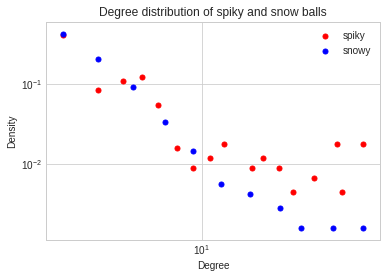

In [510]:
plt.xscale('log')
plt.yscale('log')
lin_x,lin_y = degree_distribution(av_dic1, mode='lin')
#plt.scatter(lin_x,lin_y,c='r',marker='x',s=10)
log_x,log_y = degree_distribution(av_dic1, mode='log',density=True)
plt.scatter(log_x,log_y,c='r',marker='.',s=100,label='spiky')
lin_x,lin_y = degree_distribution(av_dic2, mode='lin')
#plt.scatter(lin_x,lin_y,c='b',marker='x',s=10)
log_x,log_y = degree_distribution(av_dic2, mode='log',density=True)
plt.scatter(log_x,log_y,c='b',marker='.',s=100,label='snowy')
#plt.xlim((1e-4,1e-1))
#plt.ylim((.9,1e4))
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Degree distribution of spiky and snow balls')
plt.legend()
plt.show()

## Degree stats

In [87]:
count_dic = {}
for it in range(nb_iter):
    n_list = [node for node,val in node_dic.items() if val == it]
    degree_list = [degree_dic[node] for node in n_list]
    if degree_list:
        count_dic[it] = degree_list

In [88]:
match_size = len(count_dic.keys())
x = np.zeros((1,match_size))
x_mean = np.zeros((1,match_size))
x_std = np.zeros((1,match_size))
for idx,(nb_match,degrees) in enumerate(count_dic.items()):
    x[0,idx] = nb_match
    x_mean[0,idx] = np.mean(np.array(degrees))
    x_std[0,idx] = np.std(np.array(degrees))

In [89]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

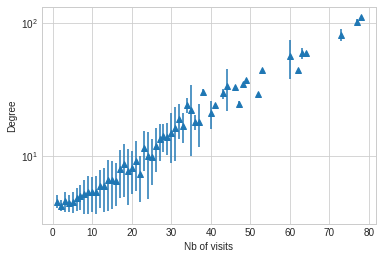

In [119]:
plt.errorbar(x,x_mean, x_std, linestyle='None', marker='^')
plt.xlabel('Nb of visits')
plt.ylabel('Degree (mean and deviation)')
plt.yscale('log')
plt.show()

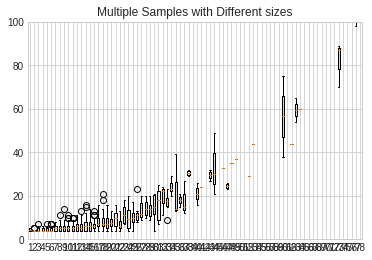

In [91]:
data = []
for idx in range(1,max(count_dic.keys())+1):
    if idx in count_dic:
        data.append(count_dic[idx])
    else:
        data.append(np.array([0]))
#data = [v for k,v in count_dic.items()]
fig7, ax7 = plt.subplots()
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data)
ax7.set(ylim=(0, 100))
plt.show()

In [81]:
import seaborn as sns

(0, 90)

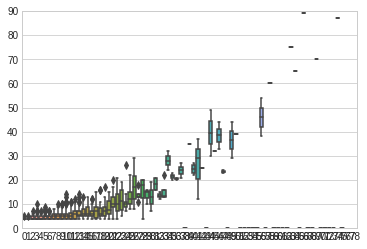

In [82]:
sns.boxplot(data=data)
plt.ylim(0,90)

# visits vs degree

In [237]:
def degrees_visits(node_dic,degree_dic):
    match_size = len(node_dic.keys())
    visits = np.zeros((1,match_size))
    degrees = np.zeros((1,match_size))
    for idx,node in enumerate(node_dic):
        visits[0,idx] = node_dic[node]
        degrees[0,idx] = degree_dic[node]
    return degrees, visits

In [238]:
degrees1,visits1 = degrees_visits(node_dic1, degree_dic1)
degrees2,visits2 = degrees_visits(node_dic2, degree_dic2)

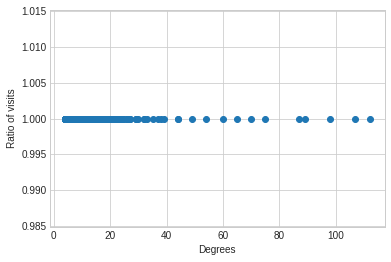

In [239]:
#plt.scatter(degrees1,visits1/nb_iter)
plt.scatter(degrees2,visits2/nb_iter)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Degrees')
plt.ylabel('Ratio of visits')
plt.show()

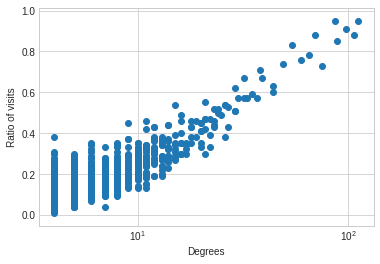

In [240]:
plt.scatter(degrees1,visits1/nb_iter)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Degrees')
plt.ylabel('Ratio of visits')
plt.show()

## appearance wrt degree

In [241]:
degrees_list = []
for node in node_dic:
    for occur in range(degree_dic[node]):
        degree_list.append(degree_dic[node])

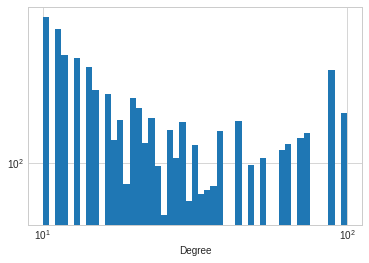

In [249]:
# log-scaled bins
bins = np.logspace(1, 2, 50)
widths = (bins[1:] - bins[:-1])

plt.hist(degree_list,bins=bins)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.show()

In [97]:
degree_list

[112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 112,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32